# ***תרגיל 4   של הפרוייקט***

# ***חלק א***

***Cell 1: Load data and basic inspection***




---



In [1]:
import pandas as pd

# Load the filtered dataset from disk (Colab path)
filtered_df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions to avoid biasing the model with repeated texts
filtered_df = filtered_df.drop_duplicates(subset=["question"], keep="first")

# Sanity check: show columns and first rows to verify the structure
print("Columns in DataFrame:")
print(filtered_df.columns)

print("\nFirst 5 rows:")
print(filtered_df.head())

# Show global label distribution for 'level' (if exists), to understand dataset balance
if "level" in filtered_df.columns:
    print("\nGlobal distribution of 'level':")
    print(filtered_df["level"].value_counts(normalize=True))
else:
    print("\nColumn 'level' not found in DataFrame.")


Columns in DataFrame:
Index(['question', 'level'], dtype='object')

First 5 rows:
                                            question   level
0  Which magazine was started first Arthur's Maga...  medium
1  The Oberoi family is part of a hotel company t...  medium
2  Musician and satirist Allie Goertz wrote a son...    hard
3    What nationality was James Henry Miller's wife?  medium
4  Cadmium Chloride is slightly soluble in this c...  medium

Global distribution of 'level':
level
medium    0.628149
easy      0.198688
hard      0.173162
Name: proportion, dtype: float64


Total number of rows: 90418

Label distribution:
level
medium    56796
easy      17965
hard      15657
Name: count, dtype: int64

Average question length (in words): 17.82


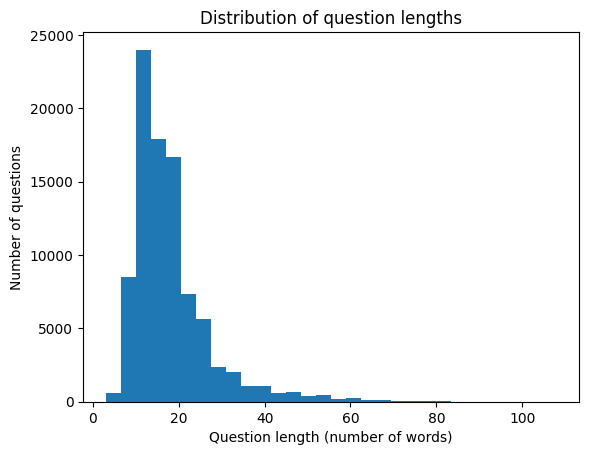

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load the dataset ---
filtered_df = pd.read_csv("/content/train-filtered_question_level.csv")

# --- Step 2: Remove duplicate questions ---
filtered_df = filtered_df.drop_duplicates(subset=["question"], keep="first")

# --- Step 3: Number of rows ---
num_rows = len(filtered_df)
print("Total number of rows:", num_rows)

# --- Step 4: Label distribution ---
label_distribution = filtered_df["level"].value_counts()

print("\nLabel distribution:")
print(label_distribution)

# --- Step 5: Compute question length (in words) ---
filtered_df["question_length_words"] = (
    filtered_df["question"]
    .astype(str)
    .apply(lambda x: len(x.split()))
)

# --- Step 6: Average question length ---
avg_question_length = filtered_df["question_length_words"].mean()
print("\nAverage question length (in words):", round(avg_question_length, 2))

# --- Step 7: Question length distribution (histogram) ---
plt.figure()
plt.hist(filtered_df["question_length_words"], bins=30)
plt.xlabel("Question length (number of words)")
plt.ylabel("Number of questions")
plt.title("Distribution of question lengths")
plt.show()


 ******************************************************************************************************************************************************************************************************** **bold text**

***Cell 2: Text preprocessing (tokenization + lemmatization)***

In [ ]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

# Download required NLTK resources (run once per runtime)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()
eng_stops = set(stopwords.words("english"))

# Normalize all forms of the verb "to be" into a single token "be"
BE_FORMS = {"am", "is", "are", "was", "were", "be", "been", "being"}


def get_wordnet_pos(tag: str):
    """
    Map POS tag from nltk.pos_tag to a WordNet POS tag.
    This helps the lemmatizer pick the correct base form.
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN


# Regex patterns for cleaning
# Remove URLs, emails, @handles, #hashtags
url_email_handle_re = re.compile(r"(https?://\S+|www\.\S+|\S+@\S+|[@#]\w+)", re.IGNORECASE)

# Detect any digit inside a token
digits_re = re.compile(r"\d")

# For NON-numeric tokens: remove everything except [a-z] and spaces
non_letter_re = re.compile(r"[^a-z ]+")


def process_text_value(text: str) -> str:
    """
    Full preprocessing for a single text value:
    - Remove URLs, emails, and @handles/#hashtags
    - Tokenize
    - POS tagging
    - Lemmatization with POS
    - Normalize all 'be' verb forms to 'be'
    - Any token that contains at least one digit -> '_number' (entire token)
    - For other tokens: strip punctuation/non-letters, keep only [a-z] and spaces
    - Finally, any token that still contains the substring 'number' is collapsed to '_number'
    - (Optional) Remove stopwords [currently commented out]
    - Lowercase
    Returns a cleaned string with space-separated tokens.
    """
    # Safely handle missing or non-string values
    if not isinstance(text, str):
        return ""

    # Remove URLs, emails, handles, hashtags
    t = url_email_handle_re.sub(" ", text)

    # Tokenize and POS-tag on original (cleaned) text
    tokens = word_tokenize(t)
    tagged = pos_tag(tokens)

    lemmas = []
    for tok, pos in tagged:
        # Normalize 'be' forms early to reduce sparsity
        if tok.lower() in BE_FORMS:
            lemmas.append("be")
            continue

        # Map POS tag to WordNet POS tag and lemmatize
        wn_pos = get_wordnet_pos(pos)
        lemma = lemmatizer.lemmatize(tok, wn_pos)
        lemmas.append(lemma)

    # Lowercase all tokens
    lemmas = [w.lower() for w in lemmas]

    intermediate = []
    for w in lemmas:
        # If the token contains ANY digit, replace the entire token with '_number'
        if digits_re.search(w):
            intermediate.append("_number")
            continue

        # For non-numeric tokens: remove punctuation and non-letters
        w2 = non_letter_re.sub(" ", w).strip()
        if not w2:
            # Skip tokens that became empty after cleaning
            continue

        # If cleaning produced multiple parts (e.g. "word-word" -> "word word")
        for part in w2.split():
            if not part:
                continue
            intermediate.append(part)

    # Final pass: collapse any token that still contains 'number' into '_number'
    # This guarantees we do not get '_numbera', '_numberkm', etc.
    clean_lemmas = []
    for w in intermediate:
        if "number" in w:
            clean_lemmas.append("_number")
        else:
            clean_lemmas.append(w)

    clean_lemmas = [w for w in clean_lemmas if w not in eng_stops]

    # Join tokens back into a single cleaned string
    return " ".join(clean_lemmas)


***Cell 3: Apply preprocessing to all questions***

In [ ]:
# Ensure the 'question' column exists before applying preprocessing
if "question" not in filtered_df.columns:
    raise KeyError("The DataFrame does not contain a 'question' column.")

# Apply the preprocessing function to every question in the dataset
# This creates a new column 'question_clean' that contains the normalized text
filtered_df["clean_text"] = filtered_df["question"].apply(process_text_value)

# Inspect a few examples to verify that preprocessing works as expected
print("Original vs. cleaned examples:\n")
for i in range(5):
    print(f"--- Example {i+1} ---")
    print("Original :", filtered_df.loc[filtered_df.index[i], "question"])
    print("Cleaned  :", filtered_df.loc[filtered_df.index[i], "clean_text"])
    print()


***Cell 4: TF-IDF vectorization of the preprocessed questions***

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Safety check: make sure 'clean_text' exists
if "clean_text" not in filtered_df.columns:
    raise KeyError("The DataFrame does not contain a 'clean_text' column. "
                   "Run the preprocessing cell first.")

# Define a TF-IDF vectorizer
# max_features limits vocabulary size to the most frequent terms
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,   # limit vocabulary size (you can tune this later)
    ngram_range=(1, 1),   # unigrams only
)

# Fit TF-IDF on the entire cleaned corpus and transform it to a sparse matrix
# Each row = one question, each column = one term from the vocabulary
X_tfidf = tfidf_vectorizer.fit_transform(filtered_df["clean_text"])

print("TF-IDF matrix shape (n_samples, n_features):", X_tfidf.shape)
print("(Num of documents, max_features)")

# Optional: extract labels if you need them later for supervised models / evaluation
if "level" in filtered_df.columns:
    y = filtered_df["level"].values
    print("Labels vector shape:", y.shape)
else:
    y = None
    print("No 'level' column found. y is set to None.")

# Show a small sample of feature names for sanity check
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nVocabulary size (len(feature_names)):", len(feature_names))
print("First 30 features:\n", feature_names[:60])


***Cell 5: Run K-Means for different K values***

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Choose several K values
k_values = [2, 7 ,15]
# k_values = [2]
inertia_scores = []
silhouette_scores = []

print("Running K-Means on TF-IDF matrix... (may take a bit)")

for k in k_values:
    print(f"\n--- K = {k} ---")

    # KMeans (using smart initialization k-means++)
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        max_iter=300,
        random_state=42,
        n_init=10
    )

    # Fit on full TF-IDF matrix
    kmeans.fit(X_tfidf)

    # Inertia (Elbow)
    inertia = kmeans.inertia_
    inertia_scores.append(inertia)

    # Silhouette score (requires >1 cluster)
    sil_score = silhouette_score(X_tfidf, kmeans.labels_, metric='euclidean')
    silhouette_scores.append(sil_score)

    print(f"Inertia: {inertia}")
    print(f"Silhouette Score: {sil_score}")


**Cell 6: Dimensionality reduction for clustering (TruncatedSVD)**

In [ ]:
from sklearn.decomposition import TruncatedSVD

# We reduce dimensionality because TF-IDF has many features and is sparse.
# TruncatedSVD is PCA-like but works directly on sparse matrices.
svd = TruncatedSVD(
    n_components=50,   # number of latent dimensions (you can tune this)
    random_state=42
)

# Fit SVD on the TF-IDF matrix and transform it to a dense lower-dimensional space
X_svd = svd.fit_transform(X_tfidf)

print("Original TF-IDF shape :", X_tfidf.shape)
print("Reduced SVD shape     :", X_svd.shape)

# Sum of explained variance ratio gives an idea how much information we kept
explained = svd.explained_variance_ratio_.sum()
print(f"Total explained variance (approx): {explained:.3f}")


***Cell 7: DBSCAN clustering on reduced space and comparison***

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# הגדרת גודל המדגם
SAMPLE_SIZE = 20000

print(f"Original dataset size: {X_svd.shape[0]}")

# 1. דגימה (אם צריך)
if X_svd.shape[0] > SAMPLE_SIZE:
    print(f"Dataset is too large. Sampling {SAMPLE_SIZE} random points...")
    np.random.seed(42)
    indices = np.random.choice(X_svd.shape[0], SAMPLE_SIZE, replace=False)
    X_subset = X_svd[indices]
    df_subset = filtered_df.iloc[indices].copy()
else:
    X_subset = X_svd
    df_subset = filtered_df.copy()

print(f"Running DBSCAN on {X_subset.shape[0]} samples...")

# 2. הרצת DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=50, metric='cosine', n_jobs=-1) #.........................................................................
dbscan_labels = dbscan.fit_predict(X_subset)
print("DBSCAN finished!")

# 3. שמירת תוצאות
df_subset['dbscan_cluster'] = dbscan_labels

# 4. ניתוח בסיסי
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print("\nCluster counts (Label -1 represents 'Noise'):")
print(dict(zip(unique_labels, counts)))

# 5. חישוב Silhouette Score (בטוח)
# בדיקה כמה אשכולות יש שאינם רעש
n_clusters_real = len(set(dbscan_labels) - {-1})

if n_clusters_real >= 2:
    non_noise_mask = dbscan_labels != -1
    sil = silhouette_score(X_subset[non_noise_mask], dbscan_labels[non_noise_mask])
    print(f"\nDBSCAN Silhouette Score (excluding noise): {sil:.4f}")
else:
    print(f"\nCould not calculate Silhouette Score: Found {n_clusters_real} real clusters.")
    print("Silhouette Score requires at least 2 distinct clusters.")
    print("Try adjusting 'eps' (lower it to split clusters) or 'min_samples'.")

***Cell 8: Analyze DBSCAN Clusters (Top Keywords & Sample Questions)***

In [ ]:
# === Cell 8: Questions by Category (Clusters) ===

import pandas as pd
import numpy as np

print("Printing Questions by Cluster (DBSCAN Results)...")

# 1. וידוא שמשתני המדגם קיימים
if 'df_subset' not in locals():
    df_subset = filtered_df

# 2. הוספת התוויות למדגם
df_subset['dbscan_cluster'] = dbscan_labels

unique_labels = np.sort(np.unique(dbscan_labels))

# מעבר על כל אשכול והצגת השאלות בלבד
for label in unique_labels:
    print(f"\n{'='*60}")

    if label == -1:
        print(f"CATEGORY: NOISE / UNCLASSIFIED QUESTIONS")
    else:
        print(f"CATEGORY: CLUSTER {label}")

    print(f"{'='*60}")

    # שליפת כל השאלות השייכות לאשכול הנוכחי
    cluster_questions = df_subset[df_subset['dbscan_cluster'] == label]['question'].values
    cluster_size = len(cluster_questions)

    print(f"Total questions in this category: {cluster_size}")
    print("-" * 30)

    # הצגת דוגמאות (נציג עד 15 שאלות כדי לא להציף, אתה יכול לשנות את המספר)
    display_count = min(15, cluster_size)
    for i in range(display_count):
        print(f" {i+1}. {cluster_questions[i]}")

    if cluster_size > display_count:
        print(f" ... and {cluster_size - display_count} more questions.")

print(f"\n{'='*60}")
print("Analysis Complete.")

**Cell 9: Visualization by t-SNE & PCA**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

# בדיקת משתנים
if 'X_subset' not in locals() or 'dbscan_labels' not in locals():
    raise ValueError("Missing variables! Please run the sampling & DBSCAN cell first.")

labels_to_plot = dbscan_labels
X_plot_data = X_subset

# הגבלת דגימה ל-t-SNE (אופטימיזציה)
TSNE_LIMIT = 5000
if len(labels_to_plot) > TSNE_LIMIT:
    print(f"Subsampling to {TSNE_LIMIT} points for t-SNE calculation...")
    np.random.seed(42)
    indices_tsne = np.random.choice(len(labels_to_plot), TSNE_LIMIT, replace=False)
    X_tsne_input = X_plot_data[indices_tsne]
    labels_tsne = labels_to_plot[indices_tsne]
else:
    X_tsne_input = X_plot_data
    labels_tsne = labels_to_plot

print("Running t-SNE... (This may take a minute)")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
X_tsne_2d = tsne.fit_transform(X_tsne_input)

# יצירת התרשים
plt.figure(figsize=(14, 10))

# הפרדה בין רעש לאשכולות
noise_mask = (labels_tsne == -1)
cluster_mask = ~noise_mask

# ציור הרעש (Noise) באפור בהיר מאוד
plt.scatter(X_tsne_2d[noise_mask, 0], X_tsne_2d[noise_mask, 1],
            c='lightgray', label='Noise (-1)', s=5, alpha=0.2)

# ציור האשכולות (Clusters)
scatter = plt.scatter(X_tsne_2d[cluster_mask, 0], X_tsne_2d[cluster_mask, 1],
            c=labels_tsne[cluster_mask], cmap='tab20', s=20, alpha=0.8, edgecolors='none')

plt.title('DBSCAN Clusters Visualization - t-SNE Projection', fontsize=15)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')

# הוספת Colorbar רק אם יש אשכולות
if np.any(cluster_mask):
    plt.colorbar(scatter, label='Cluster ID')

plt.legend(markerscale=3, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Cell 10: Calculating Purity Score**

In [ ]:
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import numpy as np

# וודא שאתה לוקח את התוויות המקוריות מהמדגם שהרצת עליו את ה-DBSCAN
true_labels = df_subset['level']

# חישוב ה-ARI
ari_score = adjusted_rand_score(true_labels, dbscan_labels)

# פונקציה לחישוב Purity
def calculate_purity(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(contingency_matrix.max(axis=0)) / np.sum(contingency_matrix.values)

purity_score = calculate_purity(true_labels, dbscan_labels)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Purity Score: {purity_score:.4f}")

# **חלק ב- חילוץ קשרים**

**Cell 11: Run TF-IDF and find the top words**

---



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def print_just_keywords_by_cluster(df, cluster_col, text_col, top_n=50):
    # 1. הגדרת הוקטורייזר לניקוי מילים נפוצות
    vec = TfidfVectorizer(stop_words='english')

    # 2. איחוד הטקסטים לפי אשכול (דילוג על רעש)
    relevant_data = df[df[cluster_col] != -1]
    docs = relevant_data.groupby(cluster_col)[text_col].apply(lambda x: ' '.join(x))

    # 3. חישוב TF-IDF
    tfidf_matrix = vec.fit_transform(docs)
    features = vec.get_feature_names_out()

    print("Printing Keywords for Each Cluster...")
    print("=" * 60)

    for i, cluster_id in enumerate(docs.index):
        # שליפת הציונים ומיון המילים מהחזקה לחלשה
        row = tfidf_matrix[i].toarray().flatten()
        all_word_indices = row.argsort()[::-1]

        # לקיחת המילים שיש להן משקל חיובי (עד הכמות שביקשנו)
        keywords = [features[idx] for idx in all_word_indices if row[idx] > 0][:top_n]

        cluster_size = len(df[df[cluster_col] == cluster_id])

        # הדפסת הכותרת והמילים
        print(f"CATEGORY: CLUSTER {cluster_id} ({cluster_size} questions)")
        print("-" * 30)

        # הדפסה של המילים מופרדות בפסיקים
        print(", ".join(keywords))

        print("\n" + "=" * 60 + "\n")

# הרצת הפונקציה - תדפיס את 50 המילים המובילות לכל אשכול
print_just_keywords_by_cluster(df_subset, 'dbscan_cluster', 'question', top_n=50)

# 🏷️ Final Topic Identification per Cluster

The following table summarizes the semantic interpretation of each cluster identified by DBSCAN. The labels were derived by analyzing the top TF-IDF keywords within each group:

| Cluster ID | Identified Topic Title |
| :--- | :--- |
| **0** | Historical Chronology & Governance |
| **1** | Dated Biographies & Global Events |
| **2** | Music Bands & Rock Culture |
| **3** | Authorship & Literary Works |
| **4** | Geographic Landmarks & Districts |
| **5** | Academic Institutions & Research |
| **6** | Professional Peer Comparisons |
| **7** | US Counties & Civil Geography |
| **8** | Occupational Scopes & Shared Roles |
| **9** | Aviation & International Airports |
| **10** | Creative Works & Shared Nationalities |
| **11** | Biographical Name Studies (Common Names) |
| **12** | Gaming, Boards & Software Development |
| **13** | Historical Battles & Operatic Works |
| **14** | Biographical Milestones & Relationships |
| **15** | Periodicals, Magazines & Publishing |
| **16** | US Government & Military Service |
| **17** | Global Urban Centers & Provinces |
| **18** | Music Theory & Classical Genres |
| **19** | Parliamentary Bodies & Political Parties |
| **20** | Film Festivals & International Directors |
| **21** | Territorial Origins & Bordering Regions |
| **22** | Team Sports & Athletic Positions |
| **23** | Corporate Foundations & Business Entities |
| **24** | Scientific Laws & Cultural Formulas |
| **25** | Comparative Birth Dates & Genealogy |
| **26** | Entertainment Media & Commodity Types |
| **27** | Biological Taxonomy (Genus & Species) |
| **28** | Cinematic Genres & Film Productions |
| **29** | Vocalists & Contemporary Songwriters |
| **30** | Social Activism & Political Figures |
| **31** | Public Recognition & Historical Legacy |
| **32** | Awards, Honors & Academic Prizes |
| **33** | Music Studio Albums & Discography |
| **34** | State Governance & Regional Landmarks |
| **35** | Professional Athlete Rankings (Tennis/Hockey) |
| **36** | Work Environments & Intellectual Contributions |
| **37** | Botany & Floral Species |
| **38** | Institutional Foundations & Societies |
| **39** | Screenwriting & Stage Direction |
| **40** | Animated Television & Series Production |

---